In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install SimpleITK

     |████████████████████████████████| 42.5MB 72kB/s 


In [0]:
pip freeze > reg.txt

In [0]:
!nvidia-smi

Fri Jan 10 11:58:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# SEMINARSKA NALOGA

# LOČEVANJE SLIK BOLNIKOV S PARKINSONOVO BOLEZNIJO OD SLIK ZDRAVIH KONTROL Z NEVRONSKO MREŽO

# Avtor: Luka Jensterle
#------------------------------------
from __future__ import print_function

import os
import sys
import random
import warnings

import numpy as np
import SimpleITK as itk
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import keras
from keras import initializers
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv3D, Conv3DTranspose
from keras.layers.pooling import MaxPooling3D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv3D, MaxPooling3D

import tensorflow as tf

from os.path import exists,join
from sklearn.model_selection import train_test_split
#from amslib import load_mri_brain_data

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

#dtype='float16'
#K.set_floatx(dtype)
#K.set_epsilon(1e-4)

seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [0]:
from tqdm import tqdm

MODALITIES = ('PET',) # ('t1','flair') ali ('flair',) ali ('t1',)
NUM_CLASSES = 2 # število rzredov; binarno razvrščanje (lahko tudi več kategorij oz. oznak)
DATA_PATH = './data'
folder_no = 0
pacient_no = 0
filesufix='.hdr'

# definiraj spremenljivke
TRAIN_data = []
test_data = []

TRAIN_category = [] # TRAIN lista kategorij za ločevanje med primeri: PB = [1,0], ZK = [0,1]
test_category = [] # test lista kategorij za ločevanje med primeri: PB = [1,0], ZK = [0,1]

# poišči vse podmape
patient_paths = os.listdir("/content/drive/My Drive/Colab Notebooks/data")
print('V mapi {:s} je {:d} podmap.'.format(DATA_PATH, len(patient_paths)))

# naloži podatke iz mape
for folder_no in tqdm(range(len(patient_paths))): # pojdi po vseh folderjih v mapi
    #patient_group_path = join(DATA_PATH, patient_paths[folder_no]) # ustvari pot do skupine pacientov
    #print('patient_group_path = {}'.format(patient_paths[folder_no]))
    
    patients_in_folder = os.listdir("/content/drive/My Drive/Colab Notebooks/data/" + patient_paths[folder_no]) # poišči vse paciente v folderju grupe pacientov
      
    for pacient_no in range(len(patients_in_folder)): # pojdi preko vseh pacientov v folderju grupe pacientov
        
      patient_image = '/content/drive/My Drive/Colab Notebooks/data/' + patient_paths[folder_no] + '/' + patients_in_folder[pacient_no] # ustvari pot do skupine pacientov

      if patient_paths[folder_no].find('PB_TRAIN')!=-1: # če smo v folderju PB_TRAIN
         if patients_in_folder[pacient_no].find(filesufix)!=-1: # naloži le '.hdr' file
            TRAIN_data.append(itk.ReadImage(patient_image)) # Dodaj sliko v list PB_TRAIN
            TRAIN_category.append(False) # Dodaj kategorijo za PB sliko False --> [1. 0.]
        
      elif patient_paths[folder_no].find('PB_test')!=-1: # če smo v folderju PB_test
         if patients_in_folder[pacient_no].find(filesufix)!=-1: #naloži le '.hdr' file
            test_data.append(itk.ReadImage(patient_image))
            test_category.append(False) #Dodaj kategorijo za PB sliko False --> [1. 0.]
        
      elif patient_paths[folder_no].find('ZK_TRAIN')!=-1:
          if patients_in_folder[pacient_no].find(filesufix)!=-1: #naloži le '.hdr' file
            TRAIN_data.append(itk.ReadImage(patient_image))
            TRAIN_category.append(True) #Dodaj kategorijo za ZK sliko True --> [0. 1.]'''
        
      elif patient_paths[folder_no].find('ZK_test')!=-1:
          if patients_in_folder[pacient_no].find(filesufix)!=-1: #naloži le '.hdr' file
            test_data.append(itk.ReadImage(patient_image))
            test_category.append(True) #Dodaj kategorijo za ZK sliko True --> [0. 1.]

# Ustvari izhodno učno in testno množico binarnih razredov za razvrščanje PB [1. 0.] in ZK [0. 1.]
Y_TRAIN = keras.utils.to_categorical((np.asarray(TRAIN_category)).astype('int')) # pretvori vektor oznak razreda v binarno matriko oznak tipa 1-k
Y_test = keras.utils.to_categorical((np.asarray(test_category)).astype('int')) # pretvori vektor oznak razreda v binarno matriko oznak tipa 1-k

Y_data = np.concatenate([Y_TRAIN, Y_test]) #združi PB_TRAIN_array in ZK_TRAIN_array polji skupaj

#Funkcija za konverzijo slike v array
def img2array(img):
    return np.squeeze(itk.GetArrayFromImage(img))

# prikaži eno PB in ZK sliko
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4)) #za izris 2 slik
ax1.imshow(img2array(PB_test_image[:,:,20]), cmap='hot') # , cmap='gray') Prikaže le [:,:,XX] XX rezino, pacienta z index 0
ax1.set_title('PB slika')
ax1.axis('off')
# Prikaži ZK sliko
ax2.imshow(img2array(ZK_TRAIN_image[:,:,20]), cmap='hot') # , cmap='gray') Prikaže le [:,:,XX] XX rezino, pacienta z index 0
ax2.set_title('ZK slika')
ax2.axis('off')

plt.show()

print("\n")
print('Velikost polja TRAIN_data: {}'.format(len(TRAIN_data)))
print('Velikost polja test_data: {}'.format(len(test_data)))
print('Velikost polja Y_TRAIN: {}'.format(len(Y_TRAIN)))
print('Velikost polja Y_test: {}'.format(len(Y_test)))
print("\n")

# zloži PB in ZK slike v 4d polje
TRAIN_array = np.stack(([itk.GetArrayFromImage(data) for data in TRAIN_data]), axis=0)
test_array = np.stack(([itk.GetArrayFromImage(data) for data in test_data]), axis=0)

# dodaj na koncu nov stolpec za modaliteto in ustvari 5D polje
TRAIN_array = TRAIN_array[:,:,:,:,np.newaxis]
test_array = test_array[:,:,:,:,np.newaxis]
print('Velikost polja PB_TRAIN_array: {}'.format(TRAIN_array.shape))
print('Velikost polja PB_test_array: {}'.format(test_array.shape))
print("\n")

#Naredi vhodni učni in testni array
X_data = np.concatenate([TRAIN_array, test_array]) #združi PB_TRAIN_array in ZK_TRAIN_array polji skupaj
print('Velikost polja X_data: {}'.format(X_data.shape))
print("\n")

X_TRAIN, X_test, Y_TRAIN, Y_test = train_test_split(X_data, Y_data, test_size=29, random_state=42) # SEED=42
print('Velikost polja X_TRAIN: {}'.format(X_TRAIN.shape))
print('Velikost polja X_test: {}'.format(X_test.shape))
print('Velikost polja Y_TRAIN: {}'.format(Y_TRAIN.shape))
print('Velikost polja Y_test: {}'.format(Y_test.shape))

  0%|          | 0/7 [00:00<?, ?it/s]

V mapi ./data je 7 podmap.


100%|██████████| 7/7 [01:37<00:00, 13.94s/it]




Velikost polja TRAIN_data: 99
Velikost polja test_data: 29
Velikost polja Y_TRAIN: 99
Velikost polja Y_test: 29


Velikost polja PB_TRAIN_array: (99, 69, 95, 79, 1)
Velikost polja PB_test_array: (29, 69, 95, 79, 1)
Velikost polja X_data: (128, 69, 95, 79, 1)


Velikost polja X_TRAIN: (99, 69, 95, 79, 1)
Velikost polja X_test: (29, 69, 95, 79, 1)
Velikost polja Y_TRAIN: (99, 2)
Velikost polja Y_test: (29, 2)


In [0]:
# Definicija modela
model=Sequential()
# 1. nivo
model.add(Conv3D(16, kernel_size=(3,3,3), activation='relu', input_shape=X_TRAIN.shape[1:], kernel_initializer='lecun_normal'))
model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', kernel_initializer='lecun_normal'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(rate=0.25))
# 2. nivo
model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', kernel_initializer='lecun_normal'))
model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', kernel_initializer='lecun_normal'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(rate=0.25))
# 3. nivo
model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', kernel_initializer='lecun_normal'))
#model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu')) #, kernel_initializer='lecun_normal'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(rate=0.25))
# Polno povezani nivo
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='lecun_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 67, 93, 77, 16)    448       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 65, 91, 75, 32)    13856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 65, 91, 75, 32)    128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 45, 37, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 45, 37, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 30, 43, 35, 32)    27680     


In [0]:
# hiperparametri modela
BATCH_SIZE = 16
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3

# prevajanje modela v strojno kodo
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=LEARNING_RATE), # Algoritmi za optimizacijo: Adam, Adadelta, RMSprop, SGD,...
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 99 samples, validate on 29 samples
Epoch 1/100




99/99 [==============================] - 8s 85ms/step - loss: 1.7209 - acc: 0.5354 - val_loss: 1.0865 - val_acc: 0.6897

Epoch 00001: val_loss improved from inf to 1.08647, saving model to /content/drive/My Drive/Colab Notebooks/models/model-classification.h5


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/100
99/99 [==============================] - 3s 29ms/step - loss: 0.8017 - acc: 0.6566 - val_loss: 0.6517 - val_acc: 0.6897

Epoch 00002: val_loss improved from 1.08647 to 0.65165, saving model to /content/drive/My Drive/Colab Notebooks/models/model-classification.h5
Epoch 3/100
99/99 [==============================] - 3s 29ms/step - loss: 0.8238 - acc: 0.6061 - val_loss: 5.0022 - val_acc: 0.6897

Epoch 00003: val_loss did not improve from 0.65165
Epoch 4/100
99/99 [==============================] - 3s 29ms/step - loss: 0.7443 - acc: 0.6061 - val_loss: 1.9937 - val_acc: 0.7586

Epoch 00004: val_loss did not improve from 0.65165
Epoch 5/100
99/99 [==============================] - 3s 29ms/step - loss: 0.5907 - acc: 0.6768 - val_loss: 3.7114 - val_acc: 0.5517

Epoch 00005: val_loss did not improve from 0.65165
Epoch 6/100
99/99 [==============================] - 3s 29ms/step - loss: 0.7820 - acc: 0.6465 - val_loss: 3.6491 - val_acc: 0.5517

Epoch 00006: val_loss did not improve f

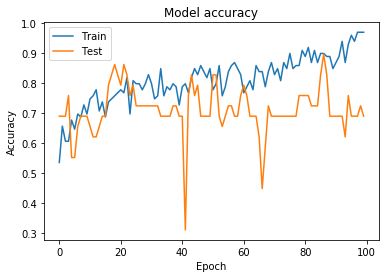

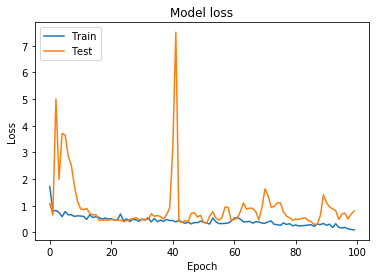

In [0]:
# pripravi izpis kriterijskih funkcij za Tensorboard
run_count = 0

while exists('./graphs/' + str(run_count)):
    run_count += 1

tbCallBack = keras.callbacks.TensorBoard(
    log_dir='./graphs/' + str(run_count), 
    histogram_freq=0, 
    write_graph=True, 
    write_images=True)

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

# zaženi učenje modela
earlystopper = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)
checkpointer = ModelCheckpoint(join('/content/drive/My Drive/Colab Notebooks/models', 'model-classification.h5'), verbose=1, save_best_only=True)
history = model.fit(X_TRAIN, Y_TRAIN,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[earlystopper, checkpointer])

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# shrani model v lokalno mapo
model.save_weights(join('/content/drive/My Drive/Colab Notebooks/models','PB-ZK_classification[: .4f].h5'.format(history.history['acc'][-1])))
print('Model je shranjen na disk!')

Model je shranjen na disk!


In [0]:
#### Vrednotenje modela ####

# naloži model
model.load_weights('/content/drive/My Drive/Colab Notebooks/models/PB-ZK_classification[1.0000].h5') #.format('+'.join(MODALITIES))))
print('Model je naložen iz diska!')

# Primerjava vrednosti kriterijskih funkcij med učno in testno zbirko
score = model.evaluate(X_TRAIN, Y_TRAIN, verbose=0)
print('Učna zbirka')
print('\tloss:', score[0])
print('\taccuracy:', score[1])
score = model.evaluate(X_test, Y_test, verbose=0)
print('Testna zbirka')
print('\tloss:', score[0])
print('\taccuracy:', score[1])





Model je naložen iz diska!
Učna zbirka
	loss: 0.10267672943647461
	accuracy: 0.9797979797979798
Testna zbirka
	loss: 0.2770720422267914
	accuracy: 0.8965517282485962
